In [2]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

## Select data

In [4]:
# Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [5]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    games = games[games.competition_name == "FIFA World Cup"]
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [6]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 64/64 [00:02<00:00, 24.67it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [11]:
A.reset_index(inplace=True)
A["index"] = A["index"] + 1
A.to_csv("../data/action-values.csv", index=False, encoding="utf-8-sig")

## Analyse VAEP ratings
### Most valuable players

In [7]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby("player_id").sum().reset_index()
)

# Add player and team names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["team_name"] = A.groupby("player_id")[["team_name"]].first().reset_index(drop=True)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)

# Show results
playersR = playersR[["player_id", "team_name", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR = playersR.sort_values("vaep_value", ascending=False, ignore_index=True)
playersR[:20]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
0,3009,France,Kylian Mbappé,3.335042,3.432357,-0.097315,495
1,5186,Russia,Denis Cheryshev,2.884800,3.285939,-0.401139,214
2,3089,Belgium,Kevin De Bruyne,2.869285,2.965952,-0.096667,716
3,20004,France,Paul Pogba,2.866437,2.761893,0.104544,676
4,5574,Germany,Toni Kroos,2.746799,2.802115,-0.055316,646
5,3621,Belgium,Eden Hazard,2.674756,2.774973,-0.100218,691
6,4319,Uruguay,Edinson Cavani,2.633588,2.618300,0.015288,226
7,3244,England,John Stones,2.601864,2.561304,0.040561,937
8,3501,Brazil,Philippe Coutinho,2.593071,2.551080,0.041991,703
9,3308,England,Kieran Trippier,2.577730,3.475827,-0.898097,690


In [8]:
playersR.sort_values("defensive_value", ascending=False)[:10]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
71,5528,Peru,Pedro Gallese,0.938272,0.232608,0.705664,119
43,3509,Belgium,Thibaut Courtois,1.108530,0.423728,0.684802,364
111,3101,Belgium,Vincent Kompany,0.669809,0.104889,0.564920,542
85,3444,Croatia,Danijel Subašić,0.855281,0.329523,0.525758,321
73,5622,Sweden,Robin Olsen,0.907231,0.383787,0.523444,176
90,5504,Argentina,Éver Banega,0.809302,0.302768,0.506533,440
97,5267,Uruguay,Fernando Muslera,0.738031,0.299578,0.438453,194
129,5619,South Korea,Cho Hyun-Woo,0.588475,0.176767,0.411707,121
105,5597,Costa Rica,Keylor Navas,0.707204,0.311354,0.395850,138
128,3240,Australia,Mat Ryan,0.594473,0.206228,0.388245,202


In [10]:
playersR[playersR.team_name == "South Korea"]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
24,3083,South Korea,Son Heung-Min,1.539923,1.685215,-0.145292,229
33,5604,South Korea,Kim Young-Gwon,1.339252,1.280336,0.058915,181
129,5619,South Korea,Cho Hyun-Woo,0.588475,0.176767,0.411707,121
205,5618,South Korea,Jung Woo-Young,0.315286,0.343271,-0.027985,138
245,5608,South Korea,Lee Yong,0.225842,0.293330,-0.067488,236
298,5986,South Korea,Hong Chul,0.137045,0.124260,0.012784,74
309,5988,South Korea,Ju Se-Jong,0.119194,0.152508,-0.033314,88
311,3605,South Korea,Ki Sung-Yeung,0.118675,0.102121,0.016555,171
365,6323,South Korea,Yun Young-Sun,0.032769,0.005961,0.026808,25
379,6325,South Korea,Ko Yo-Han,0.014980,0.012887,0.002094,11


In [36]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
352,5574,Germany,Toni Kroos,2.746799,2.802115,-0.055316,646,289,0.855405,0.872631,-0.017226
152,5186,Russia,Denis Cheryshev,2.884800,3.285939,-0.401139,214,312,0.832154,0.947867,-0.115713
451,5674,Senegal,Moussa Wagué,1.717616,1.685831,0.031785,168,208,0.743199,0.729446,0.013753
251,5473,Nigeria,Ahmed Musa,1.774202,1.787184,-0.012982,162,220,0.725810,0.731121,-0.005311
525,6196,Colombia,Yerry Mina,2.425029,2.295718,0.129312,325,315,0.692866,0.655919,0.036946
121,4319,Uruguay,Edinson Cavani,2.633588,2.618300,0.015288,226,355,0.667670,0.663794,0.003876
356,5578,Germany,Jérôme Boateng,1.241695,1.259150,-0.017455,374,190,0.588171,0.596439,-0.008268
469,5692,Colombia,Juan Fernando Quintero,1.889488,1.987896,-0.098408,374,309,0.550336,0.578999,-0.028663
6,3009,France,Kylian Mbappé,3.335042,3.432357,-0.097315,495,550,0.545734,0.561658,-0.015924
71,3501,Brazil,Philippe Coutinho,2.593071,2.551080,0.041991,703,453,0.515180,0.506837,0.008343


### (optional) Most valuable players per action type

In [33]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby("player_id").sum().reset_index()
)

# Add player and team names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["team_name"] = A.groupby("player_id")[["team_name"]].first().reset_index(drop=True)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)

# Show results
playersR = playersR[["player_id", "team_name", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
6,3009,France,Kylian Mbappé,3.335042,3.432357,-0.097315,495
152,5186,Russia,Denis Cheryshev,2.884800,3.285939,-0.401139,214
17,3089,Belgium,Kevin De Bruyne,2.869285,2.965952,-0.096667,716
599,20004,France,Paul Pogba,2.866437,2.761893,0.104544,676
352,5574,Germany,Toni Kroos,2.746799,2.802115,-0.055316,646
92,3621,Belgium,Eden Hazard,2.674756,2.774973,-0.100218,691
121,4319,Uruguay,Edinson Cavani,2.633588,2.618300,0.015288,226
36,3244,England,John Stones,2.601864,2.561304,0.040561,937
71,3501,Brazil,Philippe Coutinho,2.593071,2.551080,0.041991,703
50,3308,England,Kieran Trippier,2.577730,3.475827,-0.898097,690


### (optional) Inspect a Team's top 10 most valuable non-shot actions

2018-06-23 17:00:00 South Korea 1-2 Mexico 92' shot Heung-Min Son


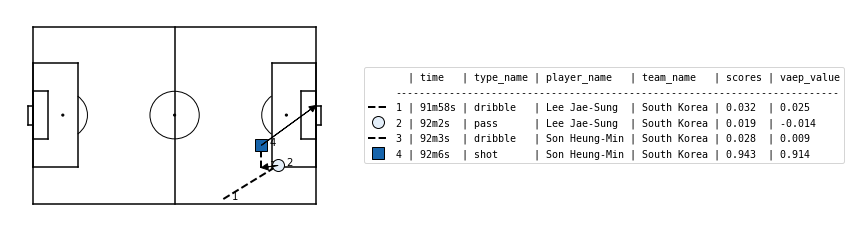

2018-06-27 16:00:00 South Korea 2-0 Germany 95' shot Heung-Min Son


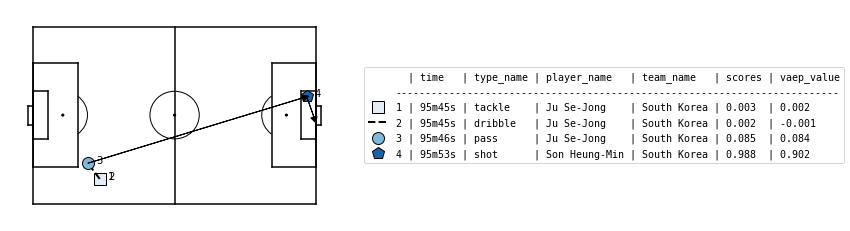

2018-06-27 16:00:00 South Korea 2-0 Germany 91' shot Young-Gwon Kim


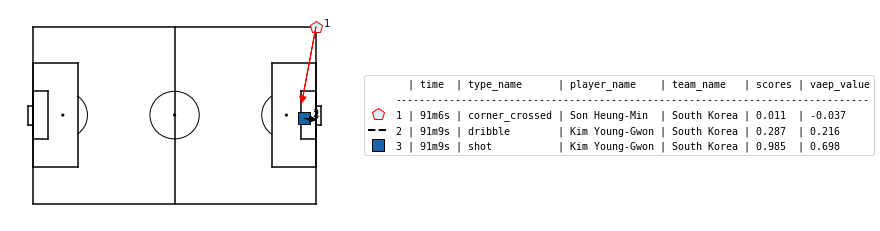

2018-06-27 16:00:00 South Korea 2-0 Germany 91' dribble Young-Gwon Kim


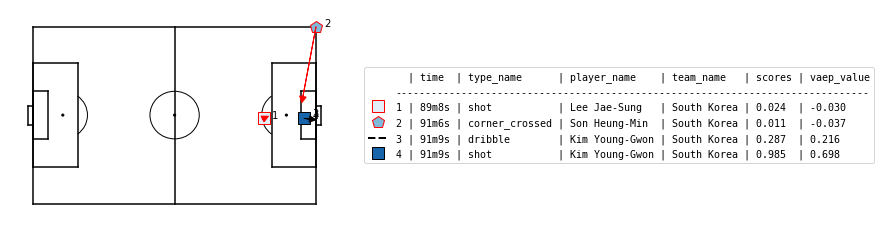

2018-06-18 14:00:00 Sweden 1-0 South Korea 73' dribble Hyeon-Woo Jo


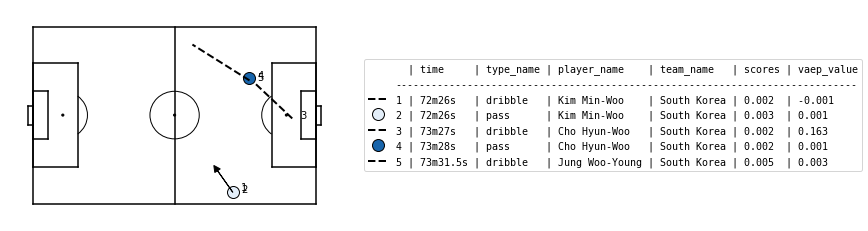

2018-06-18 14:00:00 Sweden 1-0 South Korea 5' freekick_crossed Heung-Min Son


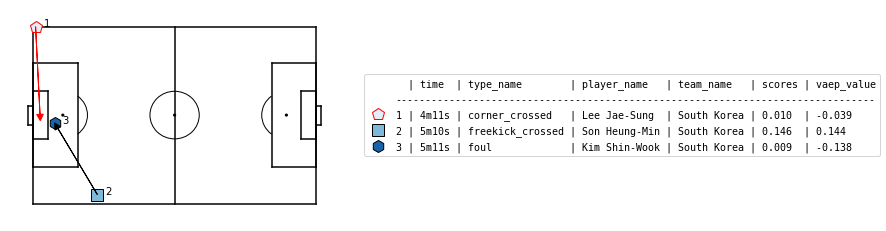

2018-06-18 14:00:00 Sweden 1-0 South Korea 55' dribble Young-Gwon Kim


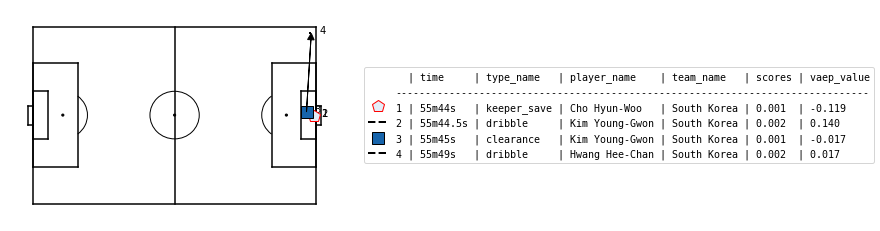

2018-06-23 17:00:00 South Korea 1-2 Mexico 74' pass Hee-Chan Hwang


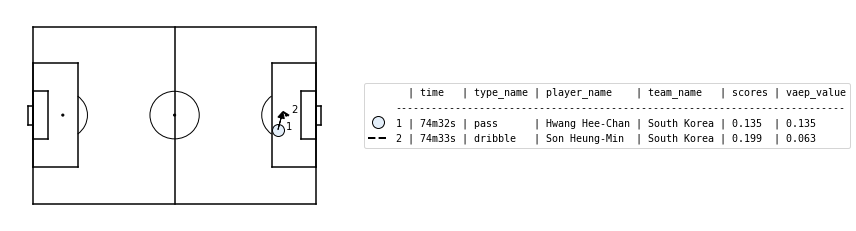

2018-06-18 14:00:00 Sweden 1-0 South Korea 31' freekick_crossed Hyun-Soo Jang


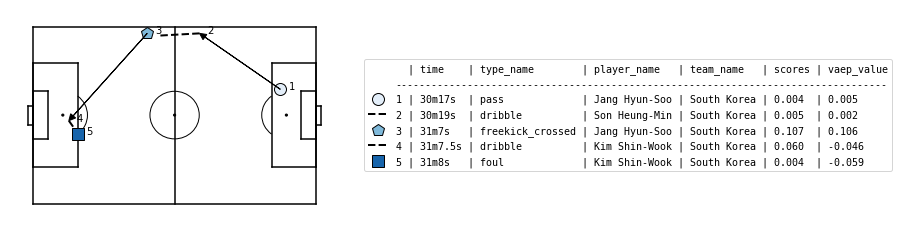

2018-06-27 16:00:00 South Korea 2-0 Germany 54' cross Yong Lee


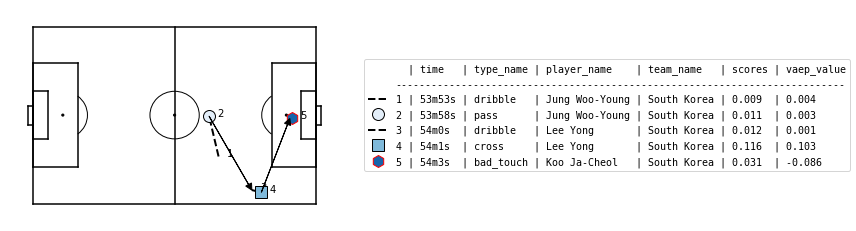

In [13]:
import matplotsoccer

team_name = "South Korea"
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == team_name] # view only actions from the team
# sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] # eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A.loc[i-3:i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
    
    g = games[games.game_id == a.game_id.values[0]].iloc[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)